In [8]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import PcmPy as pcm
import pandas as pd
import nitools as nt
import pickle


In [9]:
f = open('data_demo_smp.p', 'rb')
Y, cond_vec, part_vec, cond_names = pickle.load(f)
N = Y.shape[1]

A central concept to keep in mind to understand RSA is the second moment matrix or G:

$$ \mathsf{G} = \frac{\mathsf{YY}^T}{\mathtt{N}} $$

Where $Y$ is a matrix with experimental observations (e.g., trials) in the rows and channels (e.g., electrodes, voxels) in the columns and $N$ is the number of channels. In our example case, each row in Y contains the beta coefficients estimated in S1 for each condition. Note that the second moment matrix is different from the variance-covariance matrix:

$$ \mathsf{\Sigma} = \frac{(Y - \bar{Y})^T (Y - \bar{Y})}{N - 1} $$

Here, we subtract the column-wise mean $\bar{Y}$ from $Y$. Instead, the second moment matrix maintains information about the mean activation observed in each condition.

Let's now calculate the second moment matrix from the first run in our example data and see how it looks like:

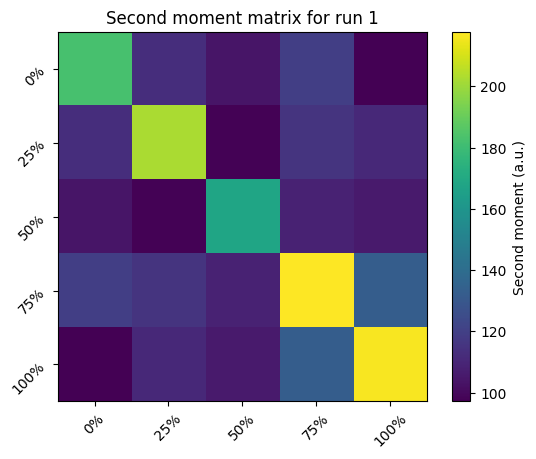

In [10]:
G = Y[:5] @ Y[:5].T / N

plt.imshow(G)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Second moment matrix for run 1')
plt.colorbar(label='Second moment (a.u.)')

From the second moment matrix it is possible to calculate the squared euclidean distances between conditions. The squared euclidean distance between two vectors $ \mathsf{y}_{i} $ and $ \mathsf{y}_{j} $ is:

$$ \mathsf{D}_{i,j}^2 = (y_{i} - y_{j})(y_{i} - y_{j})^T $$

Expanding the terms inside the parentheses:

$$ \mathsf{D}_{i,j}^2 = y_{i}y_{j}^T - 2y_{i}y_{j}^T + y_{i}y_{j}^T $$

By definition:

$$ \mathsf{G}_{i,i} = y_{i}y_{i}^T $$

Therefore, we can rewrite the squared Euclidean distance formula: 

$$ \mathsf{D}_{i,j}^2 = G_{i,i} - 2G_{i,j} + G_{j,j} $$

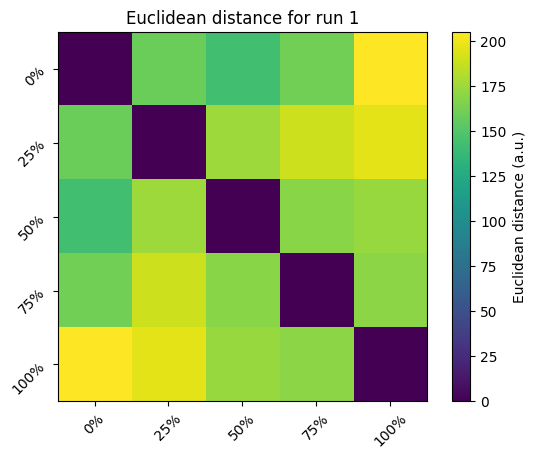

In [11]:
d_eucl = pcm.G_to_dist(G)

plt.imshow(d_eucl)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Euclidean distance for run 1')
plt.colorbar(label='Euclidean distance (a.u.)')

The problem with this distance metric is that it will be always (and trivially) higher than zero, even when there is no true distance between conditions. Because data are collected in the presence of measurement noise, the Euclidean distance between two conditions will be always larger than zero. To solve this problem and obtain an unbiased distance metric, we can calculate the G matrix by cross-validation across blocks. Without cross-validation:

$$ \mathsf{G}_{i,j} = y_{i}y_{j}^T $$

But both $ y_{i} $ and $ y_{j} $ are affected by noise $ \epsilon $:

$$ \mathsf{G}_{i,j} = (y_{i} + \epsilon)(y_{j} + \epsilon)^T $$

Expanding:

$$ \mathsf{G}_{i,j} = y_{i}y_{j}^T + y_{i}\epsilon^T + \epsilon y_{j}^T + \epsilon \epsilon^T $$

$ y_{i}\epsilon^T=0 $ because noise is by definition orthogonal to the data:

$$ \mathsf{G}_{i,j} = y_{i}y_{j}^T + \epsilon \epsilon^T $$

Yet if $ y_{i} $ and $ y_{j} $ are activity patterns 


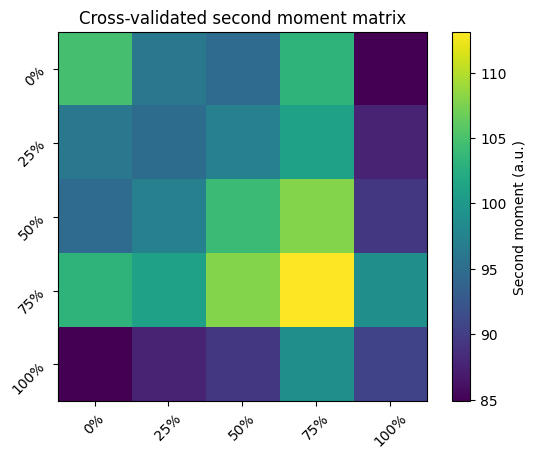

In [12]:
G_cv, _ = pcm.est_G_crossval(Y, cond_vec, part_vec)

plt.imshow(G_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated second moment matrix')
plt.colorbar(label='Second moment (a.u.)')

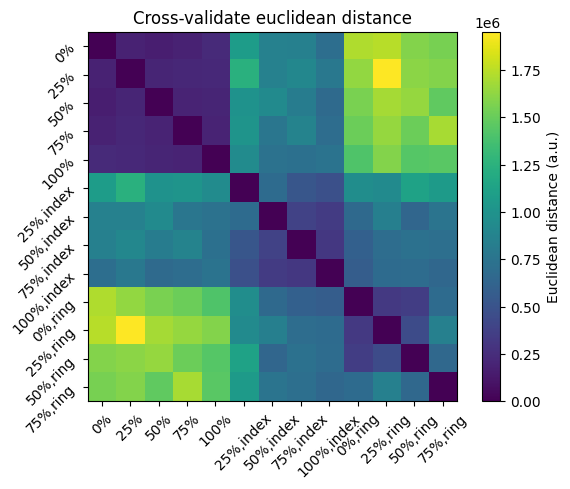

In [6]:
d_eucl_cv = pcm.G_to_dist(G_cv)

plt.imshow(d_eucl)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validate euclidean distance')
plt.colorbar(label='Euclidean distance (a.u.)')